# Лабораторная работа 2, вариант 7
## Классификация уровней ожирения

**Разведочный анализ и классификация с использованием нейронных сетей**

- **Датасет:** Уровни ожирения на основе привычек питания и физического состояния
- **Модели:** Полносвязная Dense НС, Двунаправленная GRU НС
- **Преобразование данных:** Min-max масштабирование
- **Метрики:** Accuracy, Balanced Accuracy, F1-score

## 2. Импорт библиотек и конфигурация

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Tuple, Dict, List
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             f1_score, classification_report, confusion_matrix)
from sklearn.feature_selection import mutual_info_classif

import keras
from keras import layers, optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

# Конфигурация
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
import random
random.seed(RANDOM_STATE)

# Настройка стиля графиков
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print(f"Keras version: {keras.__version__}")

Keras version: 3.13.1


## 3. Загрузка данных

Загрузите файл `V7_classification_lr3.csv` в Google Colab или укажите путь к файлу.

In [20]:
# Для Google Colab - загрузка файла
# from google.colab import files
# uploaded = files.upload()

# Или укажите путь к файлу
DATA_PATH = 'V7_classification_lr3.csv'

# Подготовка директории для артефактов
output_dir = Path('lab_2_artifacts')
output_dir.mkdir(exist_ok=True)

In [21]:
def load_data(file_path: str) -> pd.DataFrame:
    """Загрузить датасет с уровнями ожирения."""
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    print("=" * 60)
    print("ДАТАСЕТ ЗАГРУЖЕН")
    print("=" * 60)
    print(f"Размерность: {df.shape}")
    print(f"\nКолонки: {list(df.columns)}")
    print(f"\nТипы данных:\n{df.dtypes}")
    return df

In [22]:
df = load_data(DATA_PATH)

ДАТАСЕТ ЗАГРУЖЕН
Размерность: (2111, 17)

Колонки: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']

Типы данных:
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


## 4. Описательная статистика

In [23]:
def descriptive_stats(df: pd.DataFrame) -> None:
    """Показать описательную статистику."""
    print("\n" + "=" * 60)
    print("ОПИСАТЕЛЬНАЯ СТАТИСТИКА")
    print("=" * 60)

    # Численные признаки
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    print("\nЧисленные признаки:")
    print(df[numerical_cols].describe())

    # Категориальные признаки
    categorical_cols = df.select_dtypes(include=['object']).columns
    print("\n" + "-" * 60)
    print("КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ")
    print("-" * 60)
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())

    print("\n" + "-" * 60)
    print("ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ")
    print("-" * 60)
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("Пропущенных значений не найдено!")
    else:
        missing_pct = (missing / len(df)) * 100
        missing_df = pd.DataFrame({
            'Количество пропусков': missing,
            'Процент': missing_pct
        })
        print(missing_df[missing_df['Количество пропусков'] > 0])

In [24]:
descriptive_stats(df)


ОПИСАТЕЛЬНАЯ СТАТИСТИКА

Численные признаки:
               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%  

## 5. Визуализация распределений

In [7]:
def plot_distributions(df: pd.DataFrame, output_dir: Path) -> None:
    """Построить одномерные распределения для всех признаков."""
    print("\n" + "=" * 60)
    print("ПОСТРОЕНИЕ ОДНОМЕРНЫХ ВИЗУАЛИЗАЦИЙ")
    print("=" * 60)

    output_dir.mkdir(parents=True, exist_ok=True)

    # Численные признаки
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Гистограмма
        ax1.hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        ax1.set_xlabel(col)
        ax1.set_ylabel('Частота')
        ax1.set_title(f'Распределение {col}')
        ax1.grid(True, alpha=0.3)

        # Box plot
        ax2.boxplot(df[col].dropna(), vert=True)
        ax2.set_ylabel(col)
        ax2.set_title(f'Box Plot для {col}')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(output_dir / f'dist_{col}.png', dpi=100, bbox_inches='tight')
        plt.show()
        plt.close()

    # Категориальные признаки
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        value_counts = df[col].value_counts()
        value_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.title(f'Распределение {col}')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(output_dir / f'dist_{col}.png', dpi=100, bbox_inches='tight')
        plt.show()
        plt.close()

    # Распределение целевой переменной
    if 'NObeyesdad' in df.columns:
        plt.figure(figsize=(12, 6))
        target_counts = df['NObeyesdad'].value_counts().sort_index()
        bars = plt.bar(range(len(target_counts)), target_counts.values,
                      edgecolor='black', alpha=0.7)
        plt.xlabel('Класс ожирения')
        plt.ylabel('Количество')
        plt.title('Распределение целевой переменной (NObeyesdad)')
        plt.xticks(range(len(target_counts)), target_counts.index, rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')

        # Добавить значения на столбцы
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}\n({height/len(df)*100:.1f}%)',
                    ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.savefig(output_dir / 'target_distribution.png', dpi=100, bbox_inches='tight')
        plt.show()
        plt.close()

    print(f"Сохранено {len(numerical_cols) + len(categorical_cols)} графиков распределений")


ПОСТРОЕНИЕ ОДНОМЕРНЫХ ВИЗУАЛИЗАЦИЙ


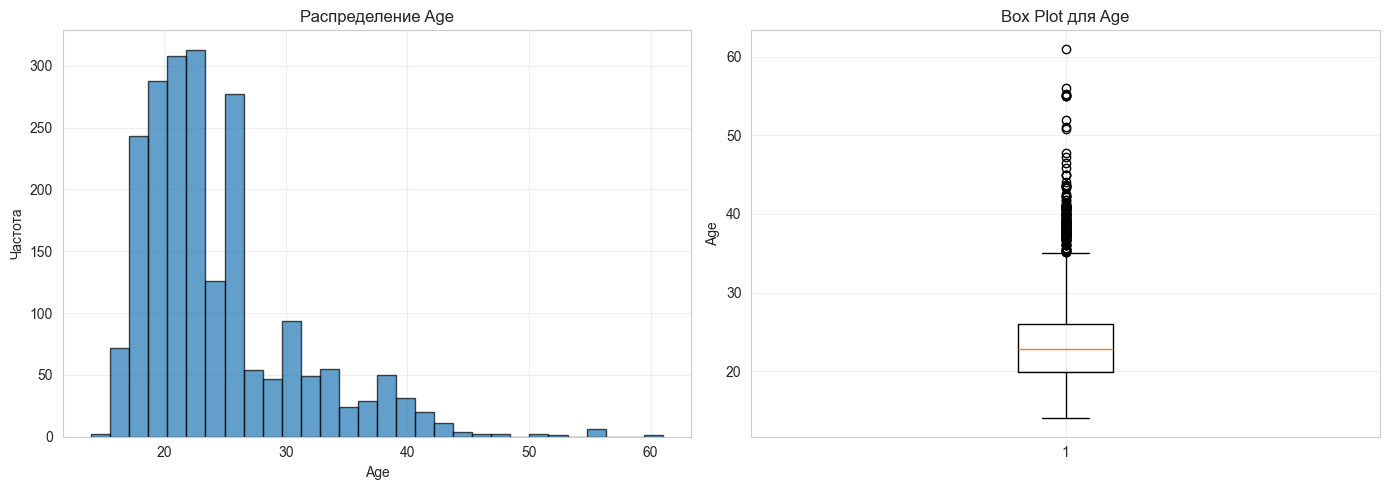

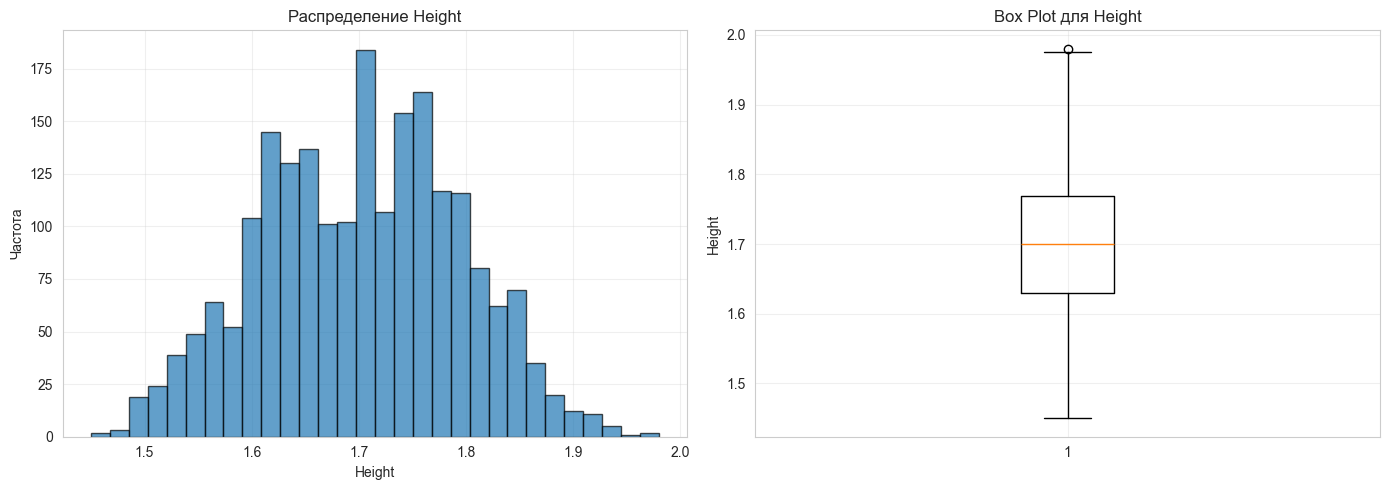

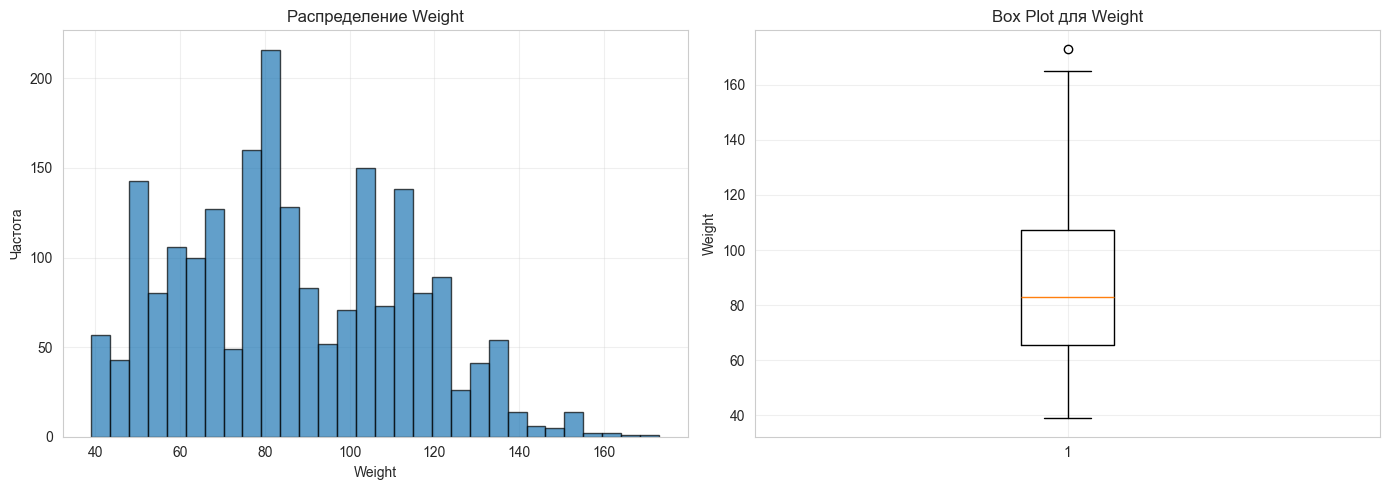

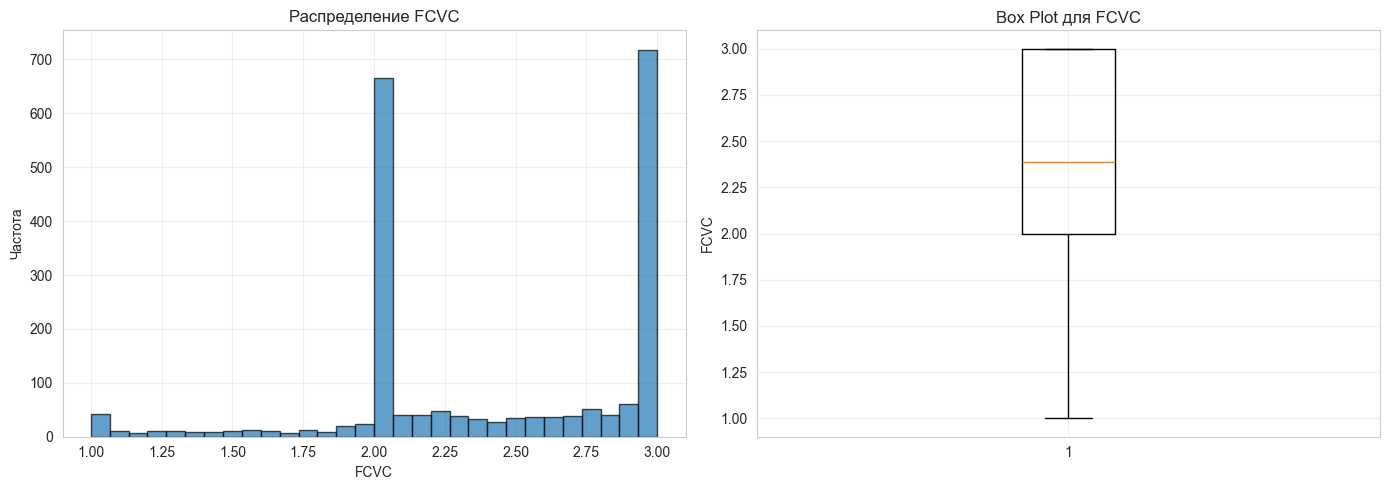

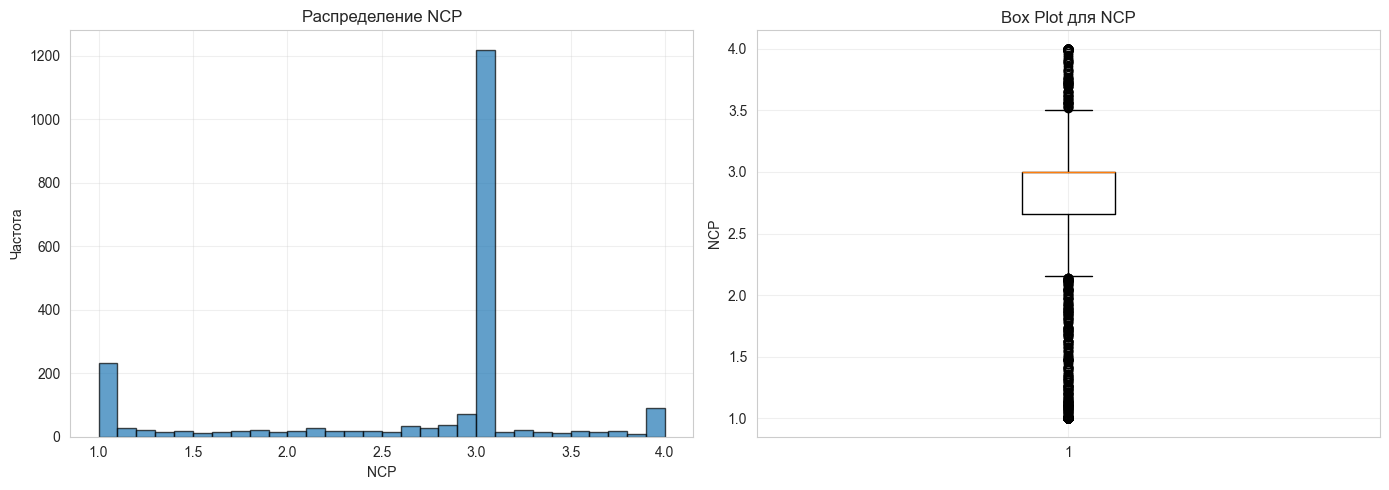

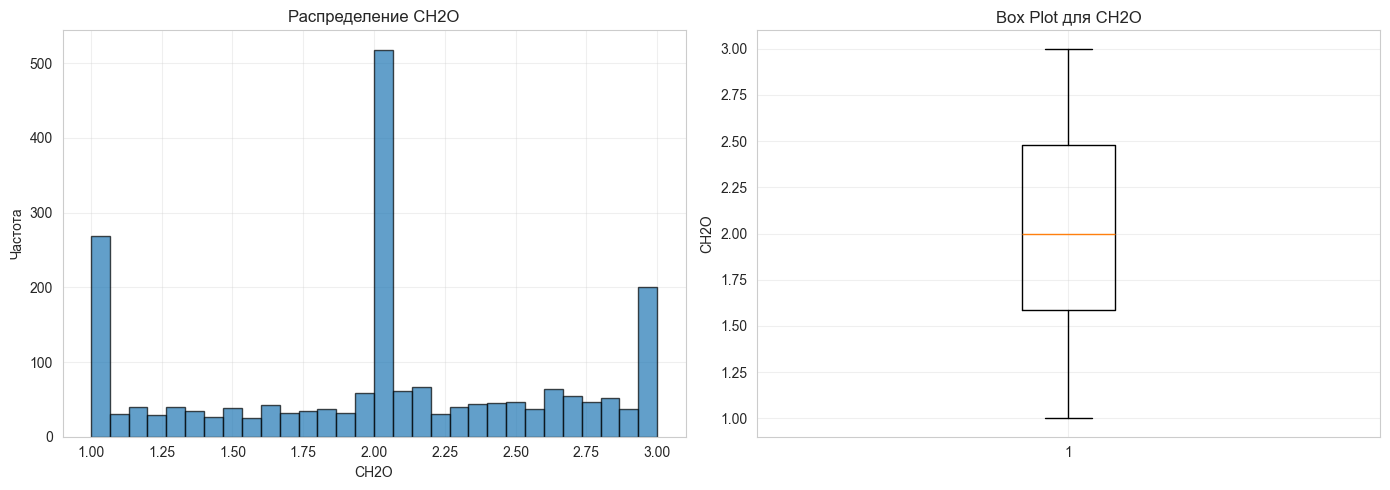

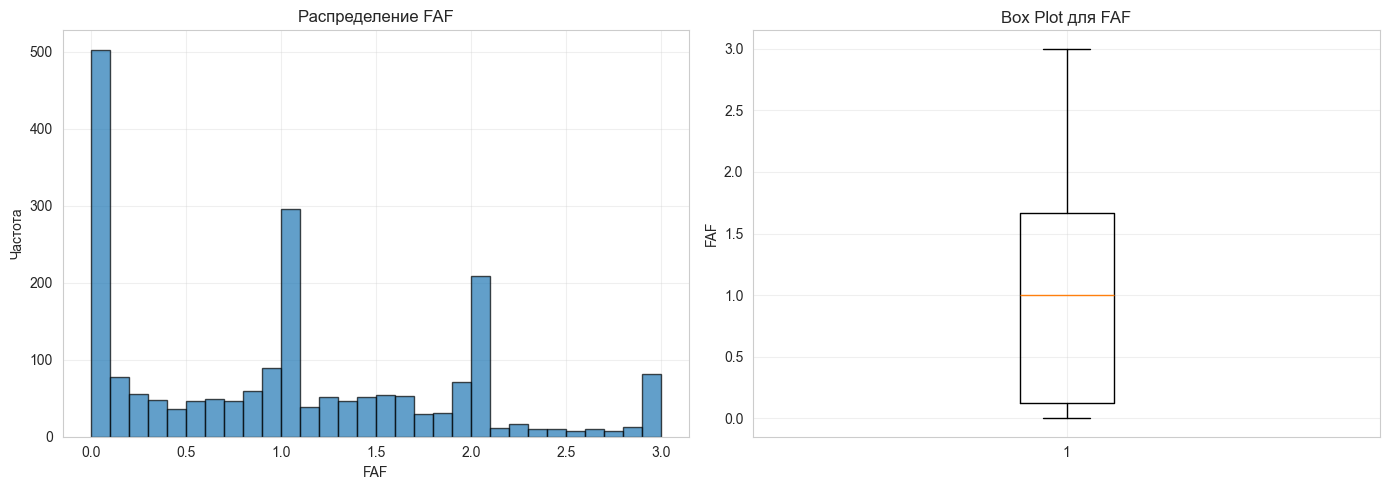

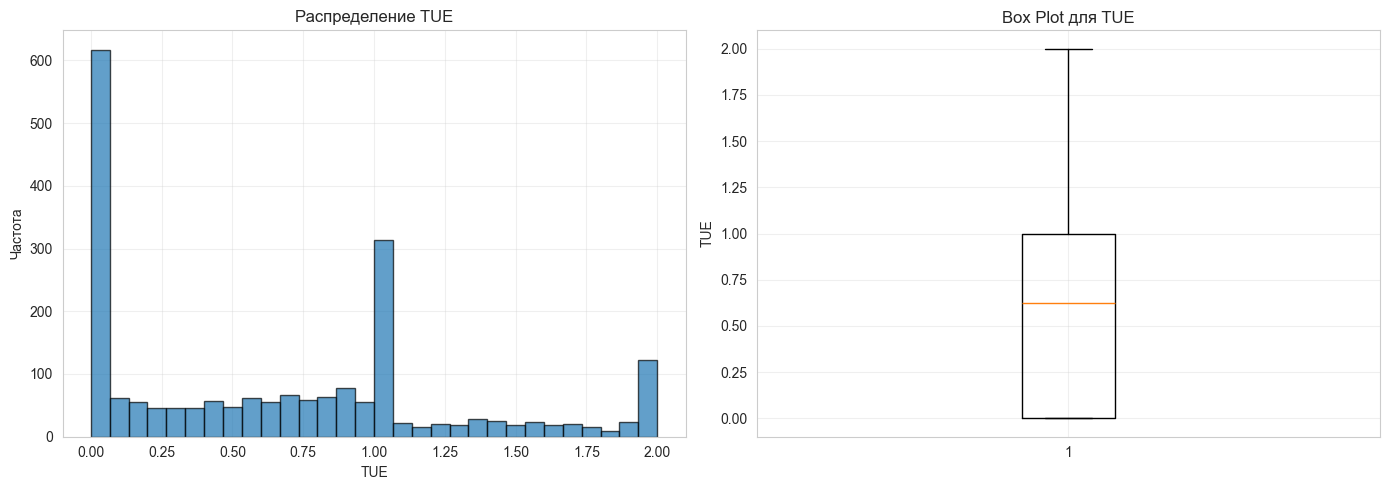

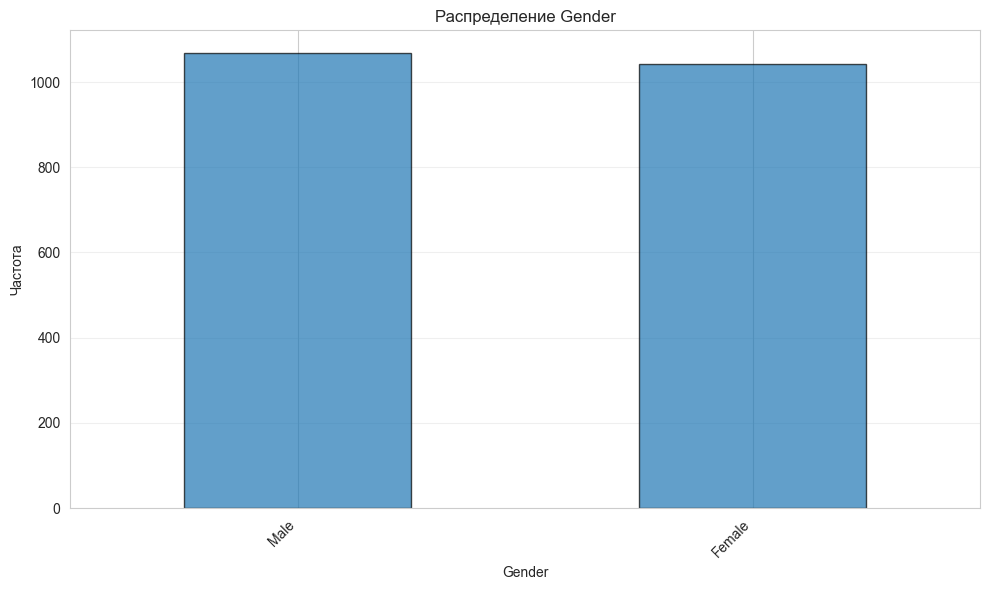

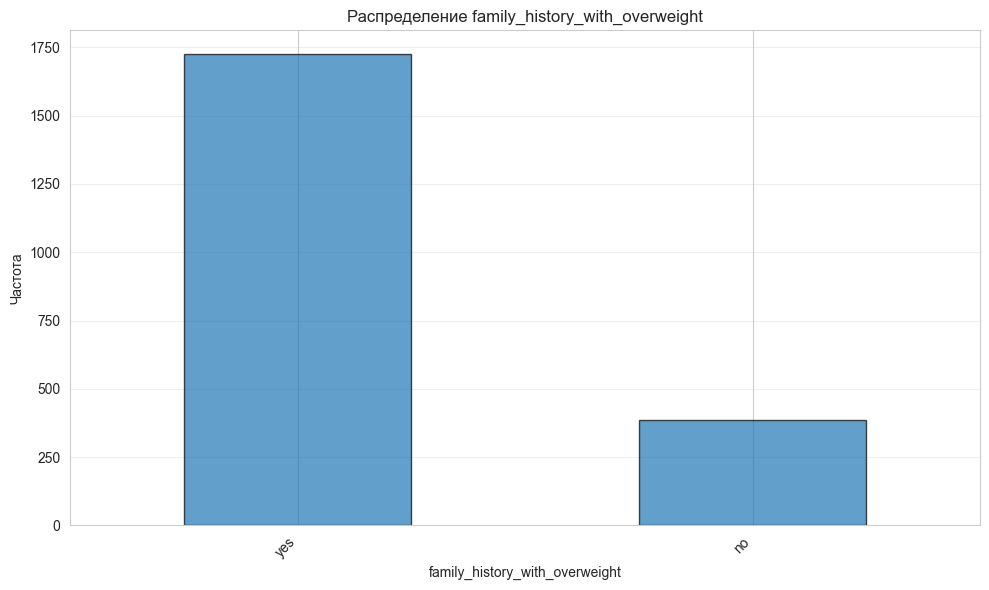

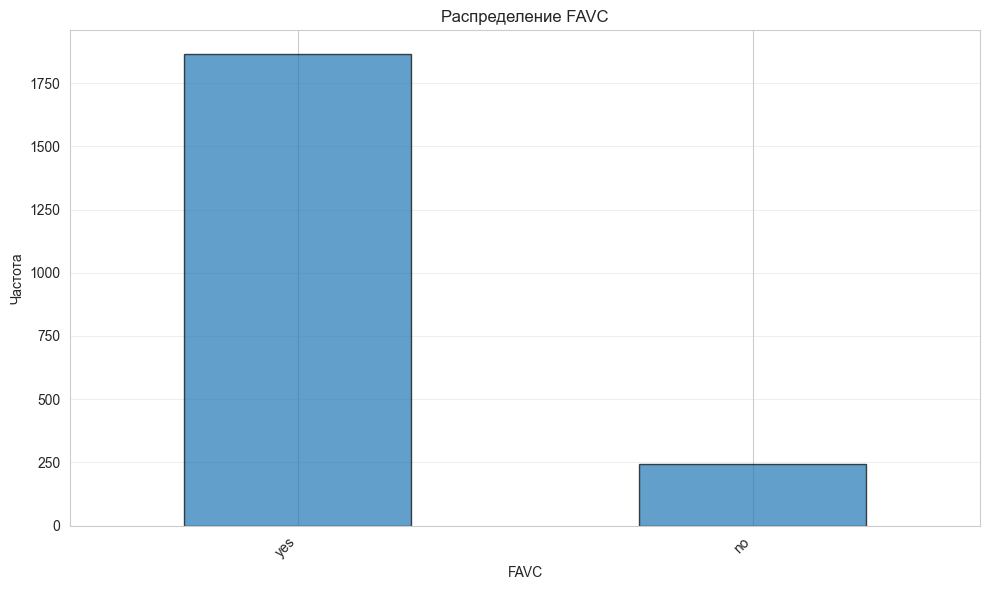

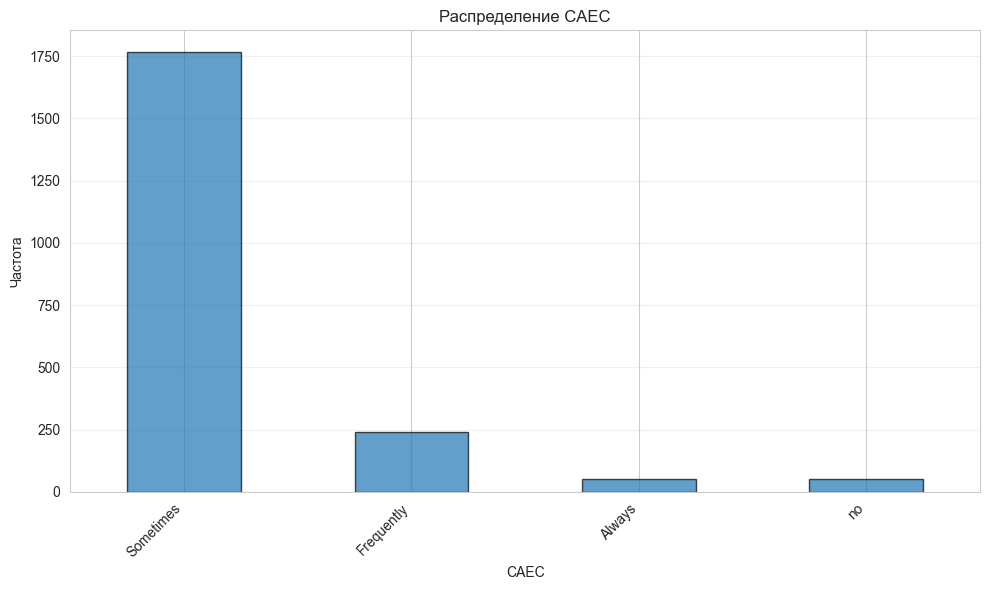

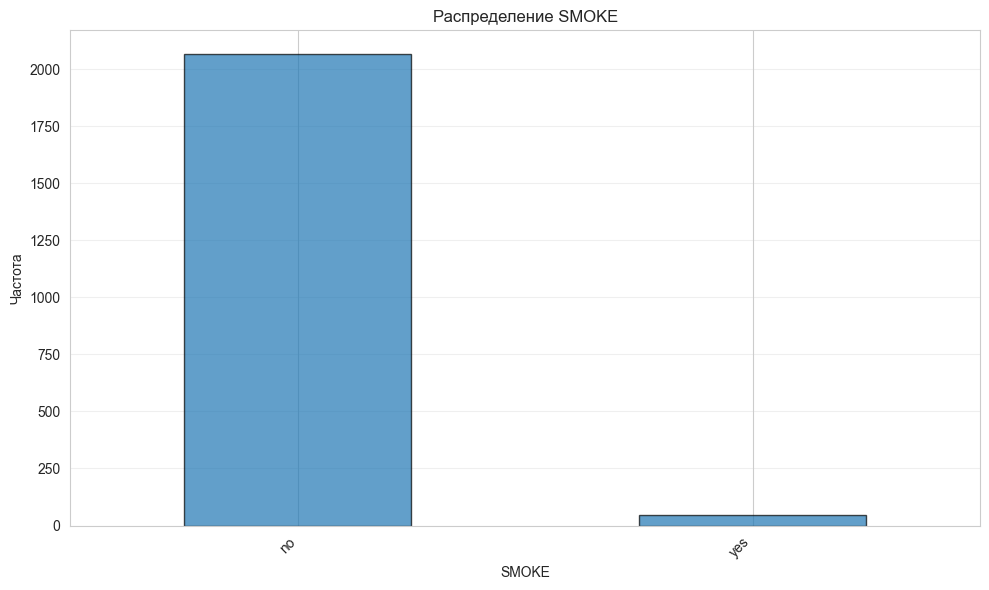

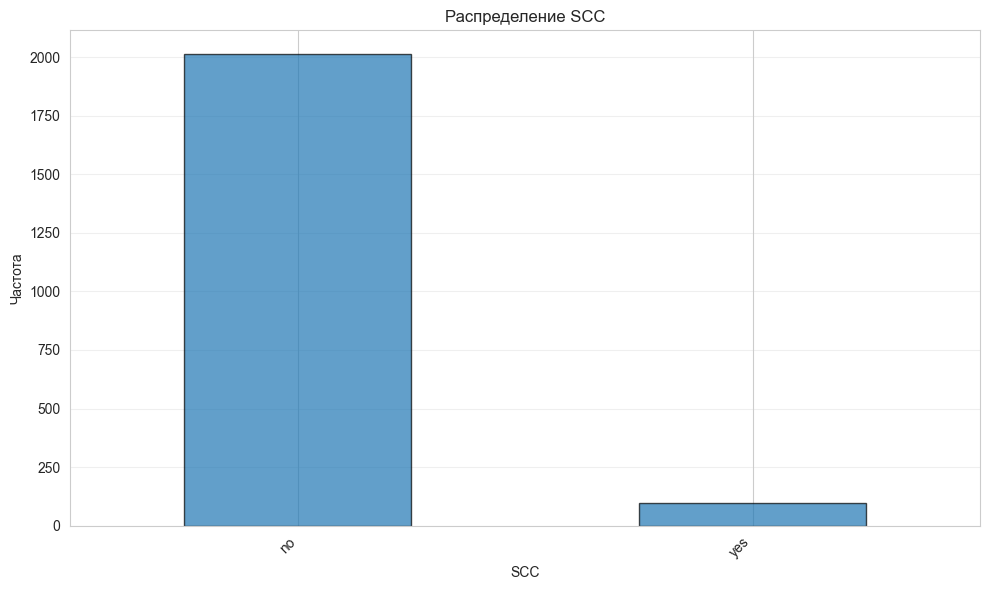

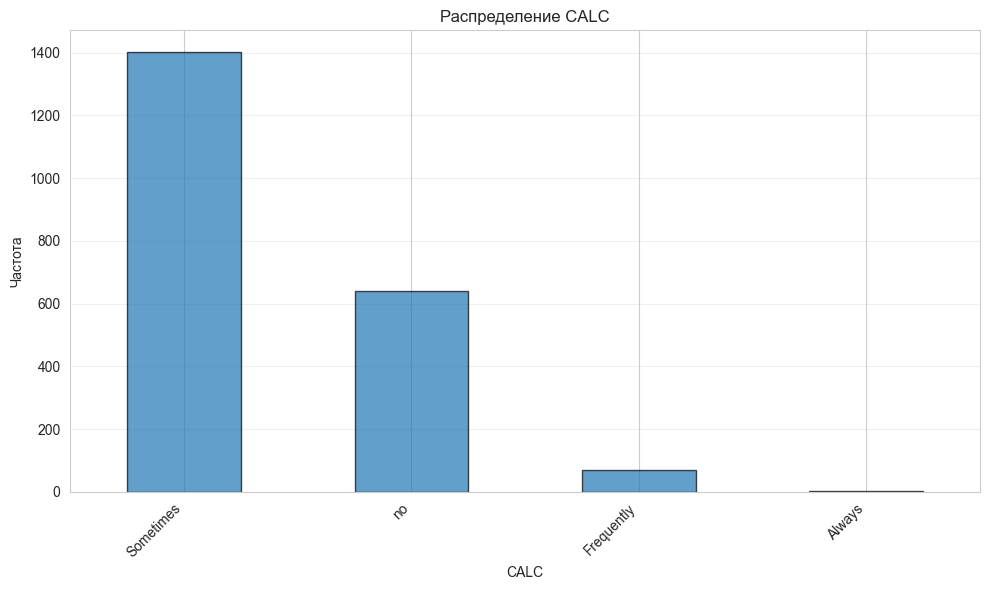

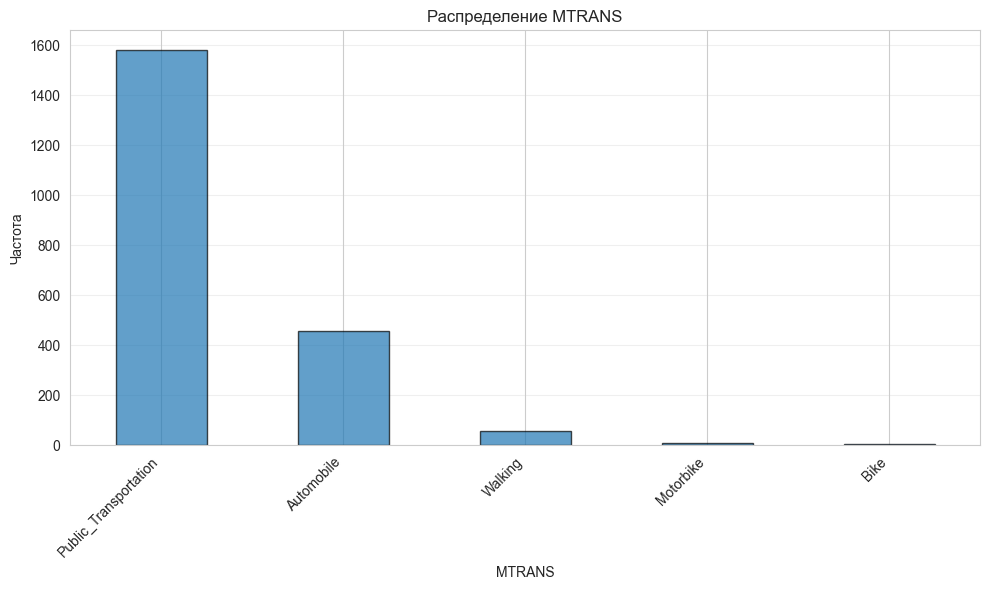

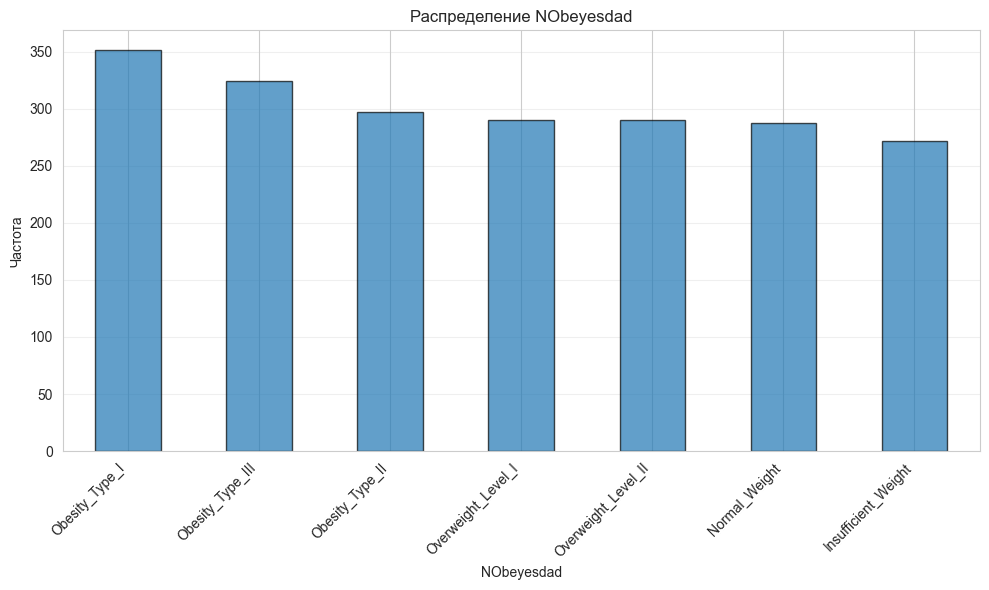

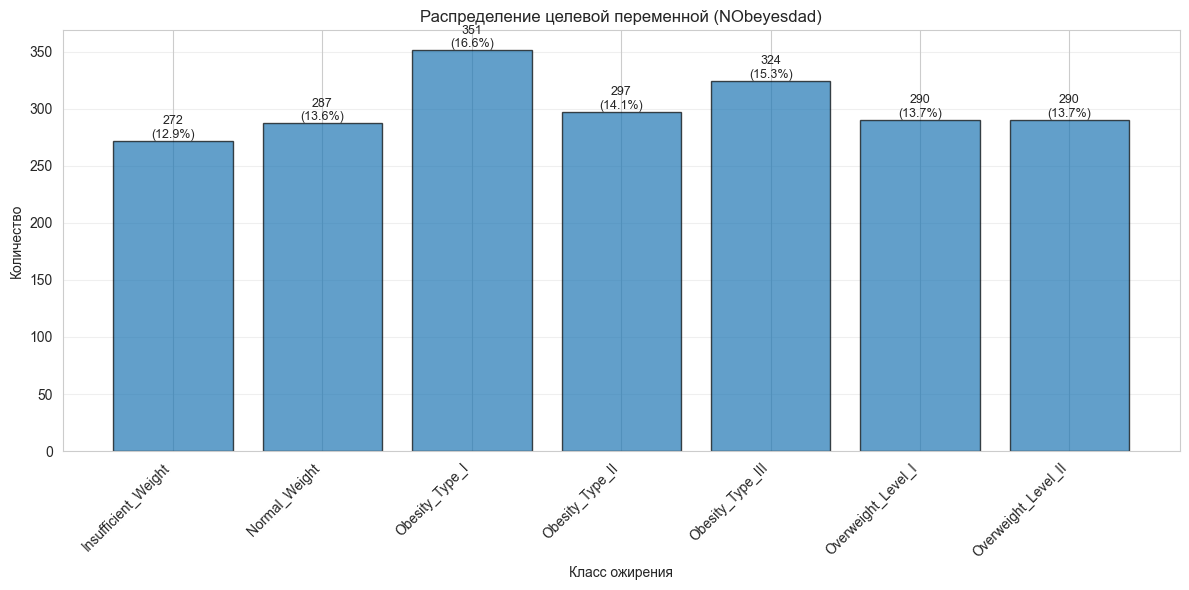

Сохранено 17 графиков распределений


In [8]:
plot_distributions(df, output_dir)

## 6. Очистка данных

In [9]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Очистить датасет: обработать пропуски и дубликаты."""
    print("\n" + "=" * 60)
    print("ОЧИСТКА ДАННЫХ")
    print("=" * 60)

    df_clean = df.copy()

    # Обработка пропусков
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype in [np.float64, np.int64]:
                median_val = df_clean[col].median()
                df_clean[col].fillna(median_val, inplace=True)
                print(f"Пропуски в {col} заполнены медианой: {median_val:.2f}")
            else:
                mode_val = df_clean[col].mode()[0]
                df_clean[col].fillna(mode_val, inplace=True)
                print(f"Пропуски в {col} заполнены модой: {mode_val}")

    # Удаление дубликатов
    n_duplicates = df_clean.duplicated().sum()
    if n_duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"Удалено дубликатов строк: {n_duplicates}")
    else:
        print("Дубликаты строк не найдены")

    print(f"Итоговая форма датасета: {df_clean.shape}")
    return df_clean

In [10]:
df_clean = clean_data(df)


ОЧИСТКА ДАННЫХ
Удалено дубликатов строк: 24
Итоговая форма датасета: (2087, 17)


## 7. Кодирование категориальных признаков

In [11]:
def encode_categoricals(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
    """Закодировать категориальные признаки."""
    print("\n" + "=" * 60)
    print("КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
    print("=" * 60)

    df_encoded = df.copy()
    encoders = {}

    # Бинарные признаки - Label Encoding
    binary_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
    for col in binary_features:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col])
            encoders[col] = le
            print(f"Label Encoding для {col}: {list(le.classes_)}")

    # Мультикатегориальные признаки - One-Hot Encoding
    multi_cat_features = ['CAEC', 'CALC', 'MTRANS']
    for col in multi_cat_features:
        if col in df_encoded.columns:
            dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=False)
            encoders[col] = list(df_encoded[col].unique())
            df_encoded = df_encoded.drop(columns=[col])
            df_encoded = pd.concat([df_encoded, dummies], axis=1)
            print(f"One-Hot Encoding для {col}: {encoders[col]}")

    print(f"\nИтоговая размерность после кодирования: {df_encoded.shape}")
    return df_encoded, encoders

In [12]:
df_encoded, encoders = encode_categoricals(df_clean)


КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
Label Encoding для Gender: ['Female', 'Male']
Label Encoding для family_history_with_overweight: ['no', 'yes']
Label Encoding для FAVC: ['no', 'yes']
Label Encoding для SMOKE: ['no', 'yes']
Label Encoding для SCC: ['no', 'yes']
One-Hot Encoding для CAEC: ['Sometimes', 'Frequently', 'Always', 'no']
One-Hot Encoding для CALC: ['no', 'Sometimes', 'Frequently', 'Always']
One-Hot Encoding для MTRANS: ['Public_Transportation', 'Walking', 'Automobile', 'Motorbike', 'Bike']

Итоговая размерность после кодирования: (2087, 27)


## 8. Корреляционный анализ

In [13]:
def plot_correlations(df: pd.DataFrame, output_dir: Path, target_col: str = 'NObeyesdad') -> None:
    """Построить тепловую карту корреляций."""
    print("\n" + "=" * 60)
    print("АНАЛИЗ КОРРЕЛЯЦИЙ")
    print("=" * 60)

    # Временно закодировать целевую переменную для корреляции
    df_temp = df.copy()
    if df_temp[target_col].dtype == 'object':
        le = LabelEncoder()
        df_temp[target_col] = le.fit_transform(df_temp[target_col])

    # Только численные признаки
    numerical_cols = df_temp.select_dtypes(include=[np.number]).columns

    # Тепловая карта корреляций
    plt.figure(figsize=(14, 12))
    correlation = df_temp[numerical_cols].corr()
    sns.heatmap(correlation, annot=False, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('Тепловая карта корреляций', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_dir / 'correlation_heatmap.png', dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()

    # Корреляции с целевой переменной
    if target_col in numerical_cols:
        correlations_with_target = correlation[target_col].sort_values(ascending=False)
        print(f"\nТоп-10 корреляций с {target_col}:")
        print(correlations_with_target.head(10))


АНАЛИЗ КОРРЕЛЯЦИЙ


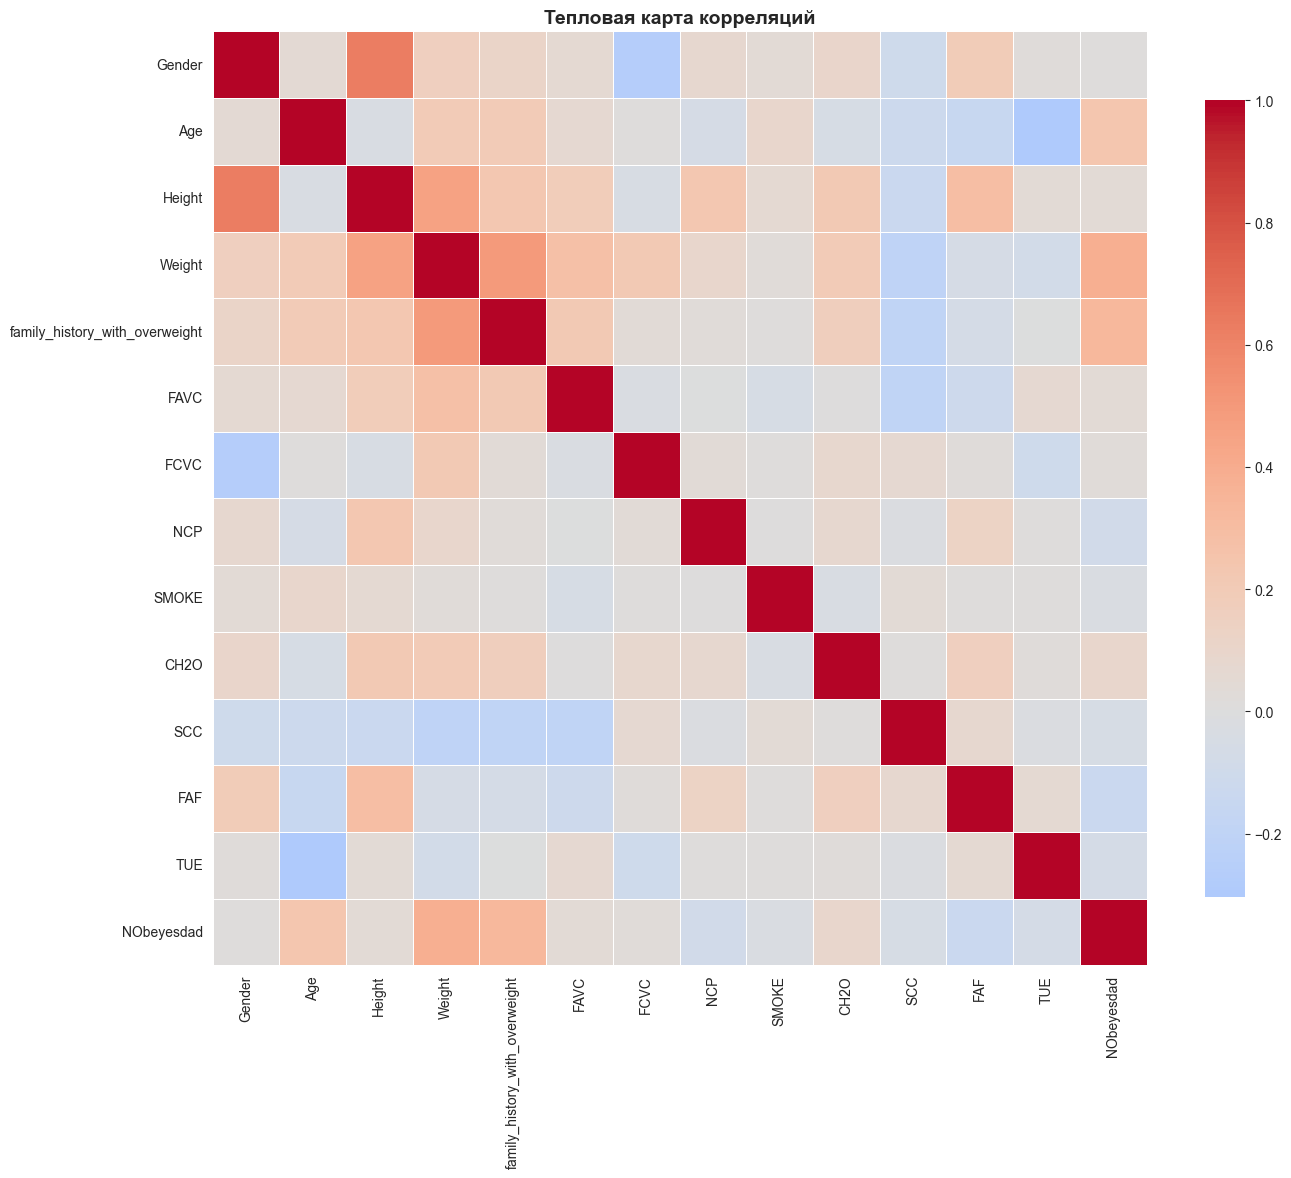


Топ-10 корреляций с NObeyesdad:
NObeyesdad                        1.000000
Weight                            0.388802
family_history_with_overweight    0.330391
Age                               0.238308
CH2O                              0.092616
FAVC                              0.041023
Height                            0.038700
FCVC                              0.025728
Gender                            0.014699
SMOKE                            -0.023341
Name: NObeyesdad, dtype: float64


In [14]:
plot_correlations(df_encoded, output_dir, target_col='NObeyesdad')

## 9. Инжиниринг признаков

In [15]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Создать доменно-специфичные инженерные признаки для предсказания ожирения."""
    print("\n" + "=" * 60)
    print("ИНЖИНИРИНГ ПРИЗНАКОВ")
    print("=" * 60)

    df_eng = df.copy()

    # BMI (Body Mass Index) - критический показатель для ожирения
    df_eng['BMI'] = df_eng['Weight'] / (df_eng['Height'] ** 2)

    # Взаимодействие возраста и веса
    df_eng['age_weight_interaction'] = df_eng['Age'] * df_eng['Weight']

    # Соотношение роста и веса
    df_eng['height_weight_ratio'] = df_eng['Height'] / (df_eng['Weight'] + 1e-6)

    # Соотношение воды и физической активности
    df_eng['water_activity_ratio'] = df_eng['CH2O'] / (df_eng['FAF'] + 1)

    # Оценка частоты питания
    df_eng['meal_frequency_score'] = df_eng['NCP'] * df_eng['FCVC']

    new_features = ['BMI', 'age_weight_interaction', 'height_weight_ratio',
                    'water_activity_ratio', 'meal_frequency_score']
    print(f"Создано новых признаков: {len(new_features)}")
    for feat in new_features:
        print(f"  - {feat}")

    print(f"Всего признаков: {df_eng.shape[1]}")
    return df_eng

In [16]:
df_eng = engineer_features(df_encoded)


ИНЖИНИРИНГ ПРИЗНАКОВ
Создано новых признаков: 5
  - BMI
  - age_weight_interaction
  - height_weight_ratio
  - water_activity_ratio
  - meal_frequency_score
Всего признаков: 32


## 10. Подготовка наборов данных

In [25]:
def select_features(X: pd.DataFrame, y: pd.Series, top_fraction: float = 0.7) -> pd.DataFrame:
    """Выбрать топ-признаки на основе взаимной информации для классификации."""
    print("\n" + "=" * 60)
    print("ОТБОР ПРИЗНАКОВ")
    print("=" * 60)

    # Закодировать целевую переменную если нужно
    y_encoded = y
    if y.dtype == 'object':
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

    # Посчитать взаимную информацию для классификации
    mi_scores = mutual_info_classif(X, y_encoded, random_state=RANDOM_STATE)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

    print(f"\nТоп-10 оценок взаимной информации:")
    print(mi_scores.head(10))

    # Выбрать топ-признаки
    n_features = max(1, int(len(mi_scores) * top_fraction))
    selected_features = mi_scores.head(n_features).index.tolist()

    print(f"\nВыбрано топ {n_features} признаков ({top_fraction*100:.0f}%):")
    for i, feat in enumerate(selected_features[:10], 1):
        print(f"  {i}. {feat} (MI: {mi_scores[feat]:.4f})")
    if len(selected_features) > 10:
        print(f"  ... и еще {len(selected_features) - 10} признаков")

    # Возвращаем только DataFrame (без списка признаков)
    return X[selected_features]


def prepare_datasets(df: pd.DataFrame, target_col: str = 'NObeyesdad') -> Dict:
    """Подготовить 4 набора данных: original, original_scaled, selected, selected_scaled."""
    print("\n" + "=" * 60)
    print("ПОДГОТОВКА НАБОРОВ ДАННЫХ")
    print("=" * 60)

    # Разделить признаки и целевую переменную
    y = df[target_col].values
    X = df.drop(columns=[target_col])

    print(f"Всего объектов: {len(y)}")
    print(f"Всего признаков: {X.shape[1]}")
    print(f"Количество классов: {len(np.unique(y))}")

    # Закодировать целевую переменную
    le_target = LabelEncoder()
    y_labels = le_target.fit_transform(y)
    print(f"\nКлассы: {list(le_target.classes_)}")

    # Отбор признаков - теперь возвращает только DataFrame
    X_selected = select_features(X, y, top_fraction=0.7)

    # Создать 4 версии датасета
    datasets = {}

    for name, features in [('original', X), ('selected', X_selected)]:
        # Стратифицированное разбиение на train/val/test (70/15/15)
        X_temp, X_test, y_temp, y_test = train_test_split(
            features, y_labels, test_size=0.15, random_state=RANDOM_STATE,
            stratify=y_labels
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.176, random_state=RANDOM_STATE,
            stratify=y_temp
        )

        # One-hot encode целевую переменную для обучения
        y_train_cat = to_categorical(y_train, num_classes=len(le_target.classes_))
        y_val_cat = to_categorical(y_val, num_classes=len(le_target.classes_))
        y_test_cat = to_categorical(y_test, num_classes=len(le_target.classes_))

        # Версия без масштабирования
        datasets[name] = {
            'X_train': X_train.values.astype(np.float32),
            'X_val': X_val.values.astype(np.float32),
            'X_test': X_test.values.astype(np.float32),
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test,
            'y_train_cat': y_train_cat,
            'y_val_cat': y_val_cat,
            'y_test_cat': y_test_cat,
            'feature_names': features.columns.tolist(),
            'scaler': None
        }

        # Версия с Min-Max масштабированием
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        datasets[f'{name}_scaled'] = {
            'X_train': X_train_scaled.astype(np.float32),
            'X_val': X_val_scaled.astype(np.float32),
            'X_test': X_test_scaled.astype(np.float32),
            'y_train': y_train,
            'y_val': y_val,
            'y_test': y_test,
            'y_train_cat': y_train_cat,
            'y_val_cat': y_val_cat,
            'y_test_cat': y_test_cat,
            'feature_names': features.columns.tolist(),
            'scaler': scaler
        }

    print(f"\nСоздано 4 набора данных:")
    for name, data in datasets.items():
        print(f"  - {name}: {data['X_train'].shape[1]} признаков, "
              f"train={len(data['y_train'])}, val={len(data['y_val'])}, "
              f"test={len(data['y_test'])}")

    return datasets, le_target

In [26]:
datasets, le_target = prepare_datasets(df_eng, target_col='NObeyesdad')
num_classes = len(le_target.classes_)


ПОДГОТОВКА НАБОРОВ ДАННЫХ
Всего объектов: 2087
Всего признаков: 31
Количество классов: 7

Классы: ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']

ОТБОР ПРИЗНАКОВ

Топ-10 оценок взаимной информации:
BMI                       1.826926
height_weight_ratio       1.429528
Weight                    1.251108
age_weight_interaction    0.882456
Age                       0.588924
meal_frequency_score      0.560431
Height                    0.415500
FCVC                      0.401730
water_activity_ratio      0.344551
CH2O                      0.298471
dtype: float64

Выбрано топ 21 признаков (70%):
  1. BMI (MI: 1.8269)
  2. height_weight_ratio (MI: 1.4295)
  3. Weight (MI: 1.2511)
  4. age_weight_interaction (MI: 0.8825)
  5. Age (MI: 0.5889)
  6. meal_frequency_score (MI: 0.5604)
  7. Height (MI: 0.4155)
  8. FCVC (MI: 0.4017)
  9. water_activity_ratio (MI: 0.3446)
  10. CH2O (MI: 0.2985)
  ... и е

## 11. Построение моделей нейронных сетей

In [27]:
def build_dense_model(input_dim: int, num_classes: int = 7,
                      hidden_units: int = 128, dropout: float = 0.3,
                      learning_rate: float = 0.001) -> keras.Model:
    """Собрать полносвязную (Dense) нейросеть для классификации."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(hidden_units // 2, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(hidden_units // 4, activation='relu'),
        layers.Dropout(dropout * 0.7),
        layers.Dense(num_classes, activation='softmax')
    ], name='Dense_Model')

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def build_bidirectional_gru_model(input_dim: int, num_classes: int = 7,
                                   gru_units_1: int = 64, gru_units_2: int = 32,
                                   dropout: float = 0.3,
                                   learning_rate: float = 0.001) -> keras.Model:
    """Собрать двунаправленную GRU нейросеть для классификации табличных данных."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim, 1)),
        # GRU слой читает последовательность
        # gru_units_1 - число нейронов внутри GRU
        # return_sequences - выдавать ли последовательность или только последний нейрон
        layers.Bidirectional(layers.GRU(gru_units_1, return_sequences=True)),
        layers.Dropout(dropout),
        layers.Bidirectional(layers.GRU(gru_units_2)),
        layers.Dropout(dropout),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout * 0.7),
        layers.Dense(num_classes, activation='softmax')
    ], name='Bidirectional_GRU_Model')

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## 12. Обучение и оценка моделей

In [28]:
def evaluate_classification_metrics(y_true: np.ndarray, y_pred: np.ndarray,
                                    y_pred_proba: np.ndarray = None) -> Dict[str, float]:
    """Посчитать метрики классификации."""
    # Конвертировать one-hot в метки если нужно
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_per_class = f1_score(y_true, y_pred, average=None)

    return {
        'accuracy': float(accuracy),
        'balanced_accuracy': float(balanced_acc),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'f1_per_class': [float(f) for f in f1_per_class]
    }


def train_model(model: keras.Model, X_train: np.ndarray, y_train: np.ndarray,
                X_val: np.ndarray, y_val: np.ndarray, epochs: int = 200,
                batch_size: int = 32, verbose: int = 0) -> keras.callbacks.History:
    """Обучить модель нейросети."""
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=0
        )
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose
    )

    return history


def train_and_evaluate_all(datasets: Dict, num_classes: int = 7, epochs: int = 200) -> Dict:
    """Обучить обе модели на всех 4 наборах данных."""
    print("\n" + "=" * 60)
    print("ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ")
    print("=" * 60)

    results = {}
    all_models = {}

    for dataset_name, dataset in datasets.items():
        print(f"\n{'-' * 60}")
        print(f"Набор данных: {dataset_name}")
        print(f"{'-' * 60}")

        X_train = dataset['X_train']
        X_val = dataset['X_val']
        y_train = dataset['y_train_cat']
        y_val = dataset['y_val_cat']

        input_dim = X_train.shape[1]
        results[dataset_name] = {}
        all_models[dataset_name] = {}

        # Обучить Dense-модель
        print(f"\nОбучение Dense-модели...")
        dense_model = build_dense_model(input_dim, num_classes=num_classes)
        train_model(dense_model, X_train, y_train, X_val, y_val,
                   epochs=epochs, verbose=0)

        # Оценить Dense
        y_train_pred = dense_model.predict(X_train, verbose=0)
        y_val_pred = dense_model.predict(X_val, verbose=0)

        train_metrics = evaluate_classification_metrics(y_train, y_train_pred)
        val_metrics = evaluate_classification_metrics(y_val, y_val_pred)

        results[dataset_name]['dense'] = {
            'train': train_metrics,
            'val': val_metrics
        }
        all_models[dataset_name]['dense'] = dense_model

        print(f"Dense - Train Acc: {train_metrics['accuracy']:.4f}, "
              f"Balanced Acc: {train_metrics['balanced_accuracy']:.4f}, "
              f"F1: {train_metrics['f1_macro']:.4f}")
        print(f"Dense - Val   Acc: {val_metrics['accuracy']:.4f}, "
              f"Balanced Acc: {val_metrics['balanced_accuracy']:.4f}, "
              f"F1: {val_metrics['f1_macro']:.4f}")

        # Обучить Bidirectional GRU модель (изменить форму данных)
        print(f"\nОбучение Bidirectional GRU модели...")
        X_train_gru = X_train.reshape(-1, input_dim, 1)
        X_val_gru = X_val.reshape(-1, input_dim, 1)

        gru_model = build_bidirectional_gru_model(input_dim, num_classes=num_classes)
        train_model(gru_model, X_train_gru, y_train, X_val_gru, y_val,
                   epochs=epochs, verbose=0)

        # Оценить GRU
        y_train_pred = gru_model.predict(X_train_gru, verbose=0)
        y_val_pred = gru_model.predict(X_val_gru, verbose=0)

        train_metrics = evaluate_classification_metrics(y_train, y_train_pred)
        val_metrics = evaluate_classification_metrics(y_val, y_val_pred)

        results[dataset_name]['bidirectional_gru'] = {
            'train': train_metrics,
            'val': val_metrics
        }
        all_models[dataset_name]['bidirectional_gru'] = gru_model

        print(f"BiGRU - Train Acc: {train_metrics['accuracy']:.4f}, "
              f"Balanced Acc: {train_metrics['balanced_accuracy']:.4f}, "
              f"F1: {train_metrics['f1_macro']:.4f}")
        print(f"BiGRU - Val   Acc: {val_metrics['accuracy']:.4f}, "
              f"Balanced Acc: {val_metrics['balanced_accuracy']:.4f}, "
              f"F1: {val_metrics['f1_macro']:.4f}")

    return results, all_models

In [29]:
results, all_models = train_and_evaluate_all(datasets, num_classes=num_classes, epochs=200)


ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ

------------------------------------------------------------
Набор данных: original
------------------------------------------------------------

Обучение Dense-модели...
Dense - Train Acc: 0.1678, Balanced Acc: 0.1429, F1: 0.0411
Dense - Val   Acc: 0.1693, Balanced Acc: 0.1429, F1: 0.0414

Обучение Bidirectional GRU модели...
BiGRU - Train Acc: 0.9842, Balanced Acc: 0.9841, F1: 0.9839
BiGRU - Val   Acc: 0.9712, Balanced Acc: 0.9702, F1: 0.9700

------------------------------------------------------------
Набор данных: original_scaled
------------------------------------------------------------

Обучение Dense-модели...
Dense - Train Acc: 0.9966, Balanced Acc: 0.9964, F1: 0.9963
Dense - Val   Acc: 0.9457, Balanced Acc: 0.9422, F1: 0.9424

Обучение Bidirectional GRU модели...
BiGRU - Train Acc: 0.9870, Balanced Acc: 0.9863, F1: 0.9862
BiGRU - Val   Acc: 0.9585, Balanced Acc: 0.9573, F1: 0.9571

------------------------------------------------------------
Набо

## 13. Поиск лучшей модели

In [32]:
def find_best_model(results: Dict, datasets: Dict, all_models: Dict,
                    le_target: LabelEncoder, output_dir: Path) -> Dict:
    """Найти лучшую модель по balanced accuracy на валидации."""
    print("\n" + "=" * 60)
    print("СРАВНЕНИЕ МОДЕЛЕЙ")
    print("=" * 60)

    # Сформировать таблицу сравнения
    comparison = []
    for dataset_name in results:
        for model_name in results[dataset_name]:
            val_metrics = results[dataset_name][model_name]['val']
            train_metrics = results[dataset_name][model_name]['train']

            comparison.append({
                'dataset': dataset_name,
                'model': model_name,
                'train_acc': train_metrics['accuracy'],
                'train_balanced_acc': train_metrics['balanced_accuracy'],
                'train_f1': train_metrics['f1_macro'],
                'val_acc': val_metrics['accuracy'],
                'val_balanced_acc': val_metrics['balanced_accuracy'],
                'val_f1': val_metrics['f1_macro']
            })

    comparison_df = pd.DataFrame(comparison)
    comparison_df = comparison_df.sort_values('val_balanced_acc', ascending=False)

    print("\nКачество всех моделей (отсортировано по Balanced Accuracy на валидации):")
    print(comparison_df.to_string(index=False))

    # Найти лучшую
    best = comparison_df.iloc[0]
    best_dataset = best['dataset']
    best_model_name = best['model']

    print(f"\n{'=' * 60}")
    print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name} на {best_dataset}")
    print(f"{'=' * 60}")
    print(f"Accuracy на валидации:          {best['val_acc']:.4f}")
    print(f"Balanced Accuracy на валидации: {best['val_balanced_acc']:.4f}")
    print(f"F1-score на валидации:          {best['val_f1']:.4f}")

    # Оценить на тестовой выборке
    dataset = datasets[best_dataset]
    model = all_models[best_dataset][best_model_name]

    X_test = dataset['X_test']
    y_test = dataset['y_test_cat']

    if best_model_name == 'bidirectional_gru':
        X_test = X_test.reshape(-1, X_test.shape[1], 1)

    y_test_pred = model.predict(X_test, verbose=0)
    test_metrics = evaluate_classification_metrics(y_test, y_test_pred)

    print(f"\nКачество на тестовой выборке:")
    print(f"Test Accuracy:          {test_metrics['accuracy']:.4f}")
    print(f"Test Balanced Accuracy: {test_metrics['balanced_accuracy']:.4f}")
    print(f"Test F1-score (macro):  {test_metrics['f1_macro']:.4f}")
    print(f"Test F1-score (weighted): {test_metrics['f1_weighted']:.4f}")

    # Детальный отчет по классам
    y_test_labels = np.argmax(y_test, axis=1)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)

    print(f"\nОтчет по классам:")
    print(classification_report(y_test_labels, y_test_pred_labels,
                               target_names=le_target.classes_))

    return {
        'dataset_name': best_dataset,
        'model_name': best_model_name,
        'dataset': dataset,
        'model': model,
        'test_metrics': test_metrics,
        'val_metrics': {
            'accuracy': best['val_acc'],
            'balanced_accuracy': best['val_balanced_acc'],
            'f1_macro': best['val_f1']
        },
        'comparison_df': comparison_df
    }

In [33]:
best_info = find_best_model(results, datasets, all_models, le_target, output_dir)


СРАВНЕНИЕ МОДЕЛЕЙ

Качество всех моделей (отсортировано по Balanced Accuracy на валидации):
        dataset             model  train_acc  train_balanced_acc  train_f1  val_acc  val_balanced_acc   val_f1
       selected bidirectional_gru   0.977397            0.976590  0.976412 0.980831          0.979493 0.979461
       original bidirectional_gru   0.984247            0.984132  0.983889 0.971246          0.970230 0.969997
selected_scaled bidirectional_gru   0.985616            0.984975  0.984837 0.968051          0.966111 0.966288
original_scaled bidirectional_gru   0.986986            0.986250  0.986232 0.958466          0.957314 0.957108
selected_scaled             dense   0.993151            0.992823  0.992698 0.958466          0.956533 0.956243
original_scaled             dense   0.996575            0.996428  0.996333 0.945687          0.942206 0.942444
       original             dense   0.167808            0.142857  0.041056 0.169329          0.142857 0.041374
       selected    

## 14. Grid Search по лучшей модели

In [34]:
def grid_search(dataset: Dict, model_type: str, num_classes: int = 7,
                epochs: int = 150, n_random_samples: int = 9) -> Dict:
    """Выполнить random search для подбора гиперпараметров (сэмплируем n_random_samples случайных комбинаций)."""
    print("\n" + "=" * 60)
    print(f"RANDOM SEARCH - {model_type.upper()}")
    print("=" * 60)

    X_train = dataset['X_train']
    X_val = dataset['X_val']
    y_train = dataset['y_train_cat']
    y_val = dataset['y_val_cat']
    input_dim = X_train.shape[1]

    if model_type == 'dense':
        param_grid = {
            'hidden_units': [64, 128, 256],
            'dropout': [0.2, 0.3, 0.4],
            'learning_rate': [0.001, 0.0005, 0.0001]
        }
    else:  # bidirectional_gru
        param_grid = {
            'gru_units_1': [32, 64, 128],
            'gru_units_2': [16, 32, 64],
            'dropout': [0.2, 0.3, 0.4],
            'learning_rate': [0.001, 0.0005, 0.0001]
        }
        X_train = X_train.reshape(-1, input_dim, 1)
        X_val = X_val.reshape(-1, input_dim, 1)

    best_score = 0
    best_params = None
    best_model = None

    # Сгенерировать все комбинации и выбрать n_random_samples случайных
    import itertools
    param_names = list(param_grid.keys())
    param_values = [param_grid[name] for name in param_names]
    all_combinations = list(itertools.product(*param_values))

    # Случайный выбор комбинаций
    n_samples = min(n_random_samples, len(all_combinations))
    combinations = random.sample(all_combinations, n_samples)

    print(f"Тестируется комбинаций параметров: {len(combinations)} из {len(all_combinations)} возможных...")

    for idx, values in enumerate(combinations, 1):
        params = dict(zip(param_names, values))

        # Собрать модель с текущими параметрами
        if model_type == 'dense':
            model = build_dense_model(
                input_dim,
                num_classes=num_classes,
                hidden_units=params['hidden_units'],
                dropout=params['dropout'],
                learning_rate=params['learning_rate']
            )
        else:
            model = build_bidirectional_gru_model(
                input_dim,
                num_classes=num_classes,
                gru_units_1=params['gru_units_1'],
                gru_units_2=params['gru_units_2'],
                dropout=params['dropout'],
                learning_rate=params['learning_rate']
            )

        # Обучить
        train_model(model, X_train, y_train, X_val, y_val,
                   epochs=epochs, batch_size=32, verbose=0)

        # Оценить
        y_val_pred = model.predict(X_val, verbose=0)
        val_metrics = evaluate_classification_metrics(y_val, y_val_pred)
        val_balanced_acc = val_metrics['balanced_accuracy']

        print(f"  [{idx}/{len(combinations)}] {params}")
        print(f"    -> Balanced Acc: {val_balanced_acc:.4f}, "
              f"Acc: {val_metrics['accuracy']:.4f}, "
              f"F1: {val_metrics['f1_macro']:.4f}")

        # Запомнить лучший вариант
        if val_balanced_acc > best_score:
            best_score = val_balanced_acc
            best_params = params
            best_model = model

    print(f"\n{'=' * 60}")
    print(f"ЛУЧШИЕ ПАРАМЕТРЫ НАЙДЕНЫ")
    print(f"{'=' * 60}")
    print(f"Параметры: {best_params}")
    print(f"Balanced Accuracy на валидации: {best_score:.4f}")

    # Оценить на валидации
    y_val_pred = best_model.predict(X_val, verbose=0)
    val_metrics = evaluate_classification_metrics(y_val, y_val_pred)

    return {
        'best_params': best_params,
        'best_model': best_model,
        'val_metrics': val_metrics
    }

In [35]:
grid_results = grid_search(
    best_info['dataset'],
    best_info['model_name'],
    num_classes=num_classes,
    epochs=150
)


RANDOM SEARCH - BIDIRECTIONAL_GRU
Тестируется комбинаций параметров: 9 из 81 возможных...
  [1/9] {'gru_units_1': 64, 'gru_units_2': 16, 'dropout': 0.2, 'learning_rate': 0.0005}
    -> Balanced Acc: 0.9667, Acc: 0.9681, F1: 0.9664
  [2/9] {'gru_units_1': 64, 'gru_units_2': 32, 'dropout': 0.3, 'learning_rate': 0.0001}
    -> Balanced Acc: 0.9498, Acc: 0.9521, F1: 0.9505
  [3/9] {'gru_units_1': 32, 'gru_units_2': 16, 'dropout': 0.4, 'learning_rate': 0.0005}
    -> Balanced Acc: 0.9610, Acc: 0.9617, F1: 0.9606
  [4/9] {'gru_units_1': 64, 'gru_units_2': 16, 'dropout': 0.2, 'learning_rate': 0.0001}
    -> Balanced Acc: 0.9635, Acc: 0.9649, F1: 0.9629
  [5/9] {'gru_units_1': 32, 'gru_units_2': 16, 'dropout': 0.3, 'learning_rate': 0.0005}
    -> Balanced Acc: 0.9634, Acc: 0.9649, F1: 0.9629
  [6/9] {'gru_units_1': 64, 'gru_units_2': 32, 'dropout': 0.3, 'learning_rate': 0.0005}
    -> Balanced Acc: 0.9601, Acc: 0.9617, F1: 0.9597
  [7/9] {'gru_units_1': 64, 'gru_units_2': 64, 'dropout': 0.4, 

## 15. Финальная оценка на тестовой выборке

In [36]:
print("\n" + "=" * 60)
print("ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ")
print("=" * 60)

X_test = best_info['dataset']['X_test']
y_test = best_info['dataset']['y_test_cat']

if best_info['model_name'] == 'bidirectional_gru':
    X_test = X_test.reshape(-1, X_test.shape[1], 1)

y_test_pred = grid_results['best_model'].predict(X_test, verbose=0)
test_metrics_after = evaluate_classification_metrics(y_test, y_test_pred)

print(f"\nДо Grid Search:")
print(f"  Test Accuracy:          {best_info['test_metrics']['accuracy']:.4f}")
print(f"  Test Balanced Accuracy: {best_info['test_metrics']['balanced_accuracy']:.4f}")
print(f"  Test F1-score:          {best_info['test_metrics']['f1_macro']:.4f}")

print(f"\nПосле Grid Search:")
print(f"  Test Accuracy:          {test_metrics_after['accuracy']:.4f}")
print(f"  Test Balanced Accuracy: {test_metrics_after['balanced_accuracy']:.4f}")
print(f"  Test F1-score:          {test_metrics_after['f1_macro']:.4f}")

improvement_acc = ((test_metrics_after['accuracy'] - best_info['test_metrics']['accuracy']) /
                   best_info['test_metrics']['accuracy'] * 100)
improvement_bal_acc = ((test_metrics_after['balanced_accuracy'] -
                       best_info['test_metrics']['balanced_accuracy']) /
                      best_info['test_metrics']['balanced_accuracy'] * 100)
improvement_f1 = ((test_metrics_after['f1_macro'] - best_info['test_metrics']['f1_macro']) /
                  best_info['test_metrics']['f1_macro'] * 100)

print(f"\nУлучшение:")
print(f"  Accuracy:          {improvement_acc:+.2f}%")
print(f"  Balanced Accuracy: {improvement_bal_acc:+.2f}%")
print(f"  F1-score:          {improvement_f1:+.2f}%")


ФИНАЛЬНАЯ ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ

До Grid Search:
  Test Accuracy:          0.9745
  Test Balanced Accuracy: 0.9731
  Test F1-score:          0.9729

После Grid Search:
  Test Accuracy:          0.9650
  Test Balanced Accuracy: 0.9625
  Test F1-score:          0.9625

Улучшение:
  Accuracy:          -0.98%
  Balanced Accuracy: -1.08%
  F1-score:          -1.07%


## 16. Детальный отчет и финальная матрица ошибок


Отчет по классам после Grid Search:
                     precision    recall  f1-score   support

Insufficient_Weight       0.97      0.97      0.97        40
      Normal_Weight       0.93      0.95      0.94        42
     Obesity_Type_I       1.00      0.98      0.99        53
    Obesity_Type_II       1.00      1.00      1.00        45
   Obesity_Type_III       1.00      1.00      1.00        49
 Overweight_Level_I       0.97      0.83      0.89        41
Overweight_Level_II       0.88      1.00      0.94        44

           accuracy                           0.96       314
          macro avg       0.97      0.96      0.96       314
       weighted avg       0.97      0.96      0.96       314



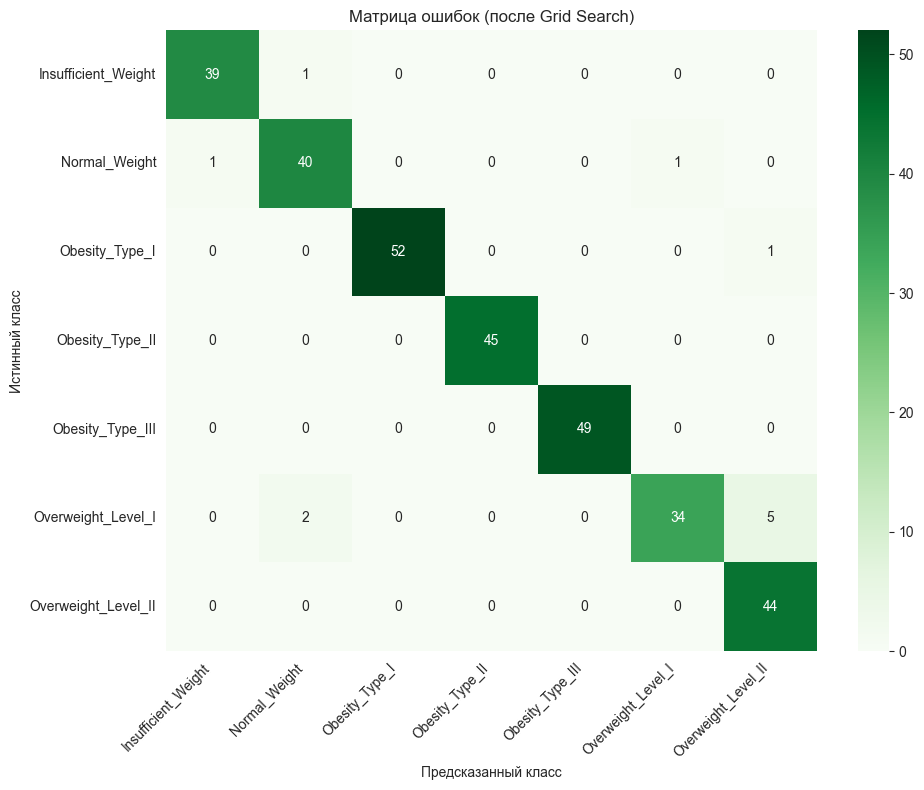

In [37]:
# Детальный отчет после grid search
y_test_labels = np.argmax(y_test, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

print(f"\nОтчет по классам после Grid Search:")
print(classification_report(y_test_labels, y_test_pred_labels,
                           target_names=le_target.classes_))

# Финальная матрица ошибок
cm = confusion_matrix(y_test_labels, y_test_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title('Матрица ошибок (после Grid Search)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(output_dir / 'confusion_matrix_final.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

## 17. Сохранение результатов

In [38]:
# Сохранение результатов
summary = {
    'best_model': best_info['model_name'],
    'best_dataset': best_info['dataset_name'],
    'num_classes': num_classes,
    'class_names': list(le_target.classes_),
    'results_before_grid_search': {
        'val_accuracy': float(best_info['val_metrics']['accuracy']),
        'val_balanced_accuracy': float(best_info['val_metrics']['balanced_accuracy']),
        'val_f1_macro': float(best_info['val_metrics']['f1_macro']),
        'test_accuracy': float(best_info['test_metrics']['accuracy']),
        'test_balanced_accuracy': float(best_info['test_metrics']['balanced_accuracy']),
        'test_f1_macro': float(best_info['test_metrics']['f1_macro']),
        'test_f1_weighted': float(best_info['test_metrics']['f1_weighted']),
        'test_f1_per_class': best_info['test_metrics']['f1_per_class']
    },
    'grid_search_params': grid_results['best_params'],
    'results_after_grid_search': {
        'val_accuracy': float(grid_results['val_metrics']['accuracy']),
        'val_balanced_accuracy': float(grid_results['val_metrics']['balanced_accuracy']),
        'val_f1_macro': float(grid_results['val_metrics']['f1_macro']),
        'test_accuracy': float(test_metrics_after['accuracy']),
        'test_balanced_accuracy': float(test_metrics_after['balanced_accuracy']),
        'test_f1_macro': float(test_metrics_after['f1_macro']),
        'test_f1_weighted': float(test_metrics_after['f1_weighted']),
        'test_f1_per_class': test_metrics_after['f1_per_class']
    },
    'improvement': {
        'accuracy_percentage': float(improvement_acc),
        'balanced_accuracy_percentage': float(improvement_bal_acc),
        'f1_macro_percentage': float(improvement_f1)
    },
    'all_models_comparison': best_info['comparison_df'].to_dict('records')
}

# Сохранить summary
with open(output_dir / 'results_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(f"\n{'=' * 60}")
print(f"Результаты сохранены в {output_dir}/results_summary.json")
print(f"Графики сохранены в {output_dir}/")
print(f"{'=' * 60}")


Результаты сохранены в lab_2_artifacts/results_summary.json
Графики сохранены в lab_2_artifacts/
